In [ ]:
from datasets import DatasetDict, Dataset, ClassLabel, Sequence, Value, Features
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from time import localtime, strftime, strptime
import os

In [ ]:
CL = 5
splits = ["train", "val", "test"]
dfs = [pd.read_csv(f"../D0/{split}.csv") for split in ["train", "val", "test"]]

filtered_dfs = list(map(lambda df: df.groupby("Dialogue_ID").filter(lambda x: x["Utterance"].count() >= CL), dfs))

def process(df):
    rows = []
    for _, conversation in df.groupby("Dialogue_ID"):
        for i in range(len(conversation) - 5 + 1):
            window = conversation[i:i + 5]
            rows.append([window["Utterance"].tolist(), window["Speaker"].tolist(), window["Emotion"].iloc[-1]])

    return pd.DataFrame(rows, columns=["text", "speaker", "labels"])

processed_dfs = map(process, filtered_dfs)

dataset_map = map(lambda df: Dataset.from_pandas(df, features=Features({
    "text": Sequence(Value(dtype="string"), length=5),
    "speaker": Sequence(Value(dtype="string"), length=5),
    "labels": ClassLabel(names=["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]),
})), processed_dfs)

dataset = DatasetDict({s: df for s, df in zip(splits, dataset_map)})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def preprocess_data(examples):
    encoding = tokenizer(examples["text"][-1], max_length=128, truncation=True)

    return encoding

tokenized_dataset = dataset.map(preprocess_data, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/858 [00:00<?, ? examples/s]

In [10]:
def get_checkpoint(epoch=0, run="latest", folder_path="results"):
    if run == "latest":
        run = max(os.listdir(folder_path), key=lambda x: strptime(x, "%b-%d-%y-%H:%M:%S"))

    checkpoint = sorted(os.listdir(f"{folder_path}/{run}"), key=lambda x: int(x.split("-")[1]))[epoch-1]

    return f"{folder_path}/{run}/{checkpoint}"

c = get_checkpoint(16, run="latest")
model = AutoModelForSequenceClassification.from_pretrained(c)

In [11]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    metrics = {
        "WA": accuracy_score(labels, predictions).tolist(),
        "UWA": balanced_accuracy_score(labels, predictions).tolist(),
        "miF1": f1_score(labels, predictions, average="micro"),
        "maF1": f1_score(labels, predictions, average="macro"),
        "wtF1": f1_score(labels, predictions, average="weighted"),
    }

    return metrics

In [12]:
loss_fn = nn.CrossEntropyLoss(torch.Tensor(1/np.bincount(dataset["train"]["labels"])).to("cuda"))

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)

        loss = loss_fn(outputs["logits"], labels)
        return (loss, outputs) if return_outputs else loss

In [13]:
training_args = TrainingArguments(
    output_dir="/tmp/tmp_trainer",
    per_device_eval_batch_size=64,
    report_to="none",
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

In [14]:
trainer.evaluate(tokenized_dataset["test"])

  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 1.4098238945007324,
 'eval_WA': 0.49287169042769857,
 'eval_UWA': 0.5092569020975651,
 'eval_miF1': 0.49287169042769857,
 'eval_maF1': 0.38063140422617625,
 'eval_wtF1': 0.48903993488083175,
 'eval_runtime': 0.884,
 'eval_samples_per_second': 2221.722,
 'eval_steps_per_second': 35.068}

In [10]:
predictions = trainer.predict(tokenized_dataset["test"])

  0%|          | 0/31 [00:00<?, ?it/s]

In [11]:
preds = pd.DataFrame(dataset["test"])
preds["pred"] = np.argmax(predictions[0], axis=1)

In [12]:
preds

,t0,t1,t2,t3,t4,s0,s1,s2,s3,s4,labels,pred
0,Why do all you're coffee mugs have numbers on ...,Oh. That's so Monica can keep track. That way ...,Y'know what?,It didn't.,"Okay, so what you used to have with Rachel, is...",Mark,Rachel,Rachel,Ross,Frank,1,0
1,Oh. That's so Monica can keep track. That way ...,Y'know what?,It didn't.,"Okay, so what you used to have with Rachel, is...","Now, wh-what, what is that like?",Rachel,Rachel,Ross,Frank,Joey,5,5
2,Y'know what?,It didn't.,"Okay, so what you used to have with Rachel, is...","Now, wh-what, what is that like?","It's so cool man, it's so, it's just 'cause be...",Rachel,Ross,Frank,Joey,Frank,1,1
3,It didn't.,"Okay, so what you used to have with Rachel, is...","Now, wh-what, what is that like?","It's so cool man, it's so, it's just 'cause be...","Yeah, yeah.",Ross,Frank,Joey,Frank,Ross,0,0
4,"Okay, so what you used to have with Rachel, is...","Now, wh-what, what is that like?","It's so cool man, it's so, it's just 'cause be...","Yeah, yeah.",Why can't I find that?,Frank,Joey,Frank,Ross,Joey,7,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1959,"I don't know what it is, I just can't take a g...","Oh, here's a great one.","Yeah, I'm not in that.","I know, but look at me: all tan.","Hey, why don't you guys go get portraits done ...",Chandler,Monica,Chandler,Monica,Phoebe,0,0
1960,"Oh, here's a great one.","Yeah, I'm not in that.","I know, but look at me: all tan.","Hey, why don't you guys go get portraits done ...",That's a good idea! I bet they have one of tho...,Monica,Chandler,Monica,Phoebe,Monica,1,1
1961,"Yeah, I'm not in that.","I know, but look at me: all tan.","Hey, why don't you guys go get portraits done ...",That's a good idea! I bet they have one of tho...,"Yeah that's great! Next to that, Chandler won'...",Chandler,Monica,Phoebe,Monica,Phoebe,0,1
1962,"I know, but look at me: all tan.","Hey, why don't you guys go get portraits done ...",That's a good idea! I bet they have one of tho...,"Yeah that's great! Next to that, Chandler won'...",Chandler what do you say?,Monica,Phoebe,Monica,Phoebe,Monica,0,0


In [13]:
for i in range(8):

    tp = (preds["labels"] == i) & (preds["pred"] == i)
    tn = (preds["labels"] != i) & (preds["pred"] != i)

    # print((sum(tp) + sum(tn))/len(preds))
    print(sum(tp) / sum(preds["labels"] == i))

0.5769230769230769
0.7920792079207921
0.5692307692307692
0.5
0.5785123966942148
0.6842105263157895
0.32653061224489793
0.04656862745098039


In [16]:
sum([0.7920792079207921,0.5692307692307692,0.5,0.5785123966942148,0.6842105263157895,0.32653061224489793])/6

0.5750939187344105

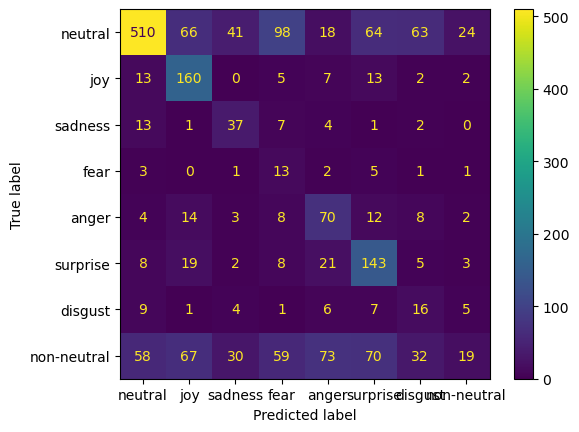

In [14]:
ConfusionMatrixDisplay.from_predictions(preds["labels"], preds["pred"], display_labels=dataset["train"].features["labels"].names)